In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def LUDecomp(A):
    N = A.shape[0]
    
    # PA = LU
    # A = P^-1 LU = P^T LU
    P = np.eye(N)
    L = np.eye(N)
    U = np.copy(A.astype(np.float))
    
    
    for n in range(N):
        
        # check whether the leading coefficient of n-th row is on the diagonal
        if U[n,n] == 0:
            for i in range(n + 1, N): # find a possible row to exchange with
                if U[i,n] != 0: # exchange n-th row with i-th row
                    P[[i,n]] = P[[n,i]] # record this operation in P
                    U[[i,n]] = U[[n,i]] # swap rows in U
                    L[[n,i],:n] = L[[i,n],:n] # swap entries in L
                    break
            else:
                raise Exception('Inverse does not exist!')
        
        # do eliminations on rows below
        for i in range(n + 1, N):
            c = U[i,n] / U[n,n]
            U[i] -= c * U[n]
            L[i,n]=c
    
    
    
    return P.T, L, U

In [3]:
def matInv(A):
    P, L, U = LUDecomp(A)
    
    # A = PLU
    # let x = A^-1
    # Ax = I
    # PLUx = I
    # LUx = P^-1 I = P^T
    
    # let Ux = y
    # Ly = P^T
    # solve y
    
    # Ux = y
    # solve x
    
    def backSub(A, B):
        # solve AX = B where
        # A is a (N, N) square matrix in lower triangular form
        # X and B are (N, M) matrix
        N = A.shape[0]
        M = B.shape[1]
        
        X = np.zeros(B.shape)
        
        for m in range(M):
            for n in range(N):
                X[n] = (B[n] - np.matmul(A[n,:n], X[:n])) / A[n,n]
        
        
        return X
    
    # Ly = P^T, solve y
    y = backSub(L, P.T)
    x = backSub(U[::-1,::-1], y[::-1])[::-1]
    
    
    return x

In [4]:
def fitRLSE(X, Y, n, l):
    # X, Y are data points
    # r is lambda (weight of regularization term)
    # n is the number of polynomial basis,
    # i.e. n - 1 is the highest order of polynomial: a_(n-1) * x^(n-1) + ... + a_0
    # coefficients of polynomials are saved in descending order
    # return: coefficient, total error
    
    if len(X) != len(Y):
        raise Exception('Datapoint size mismatched!')
    
    X = np.array(X, dtype=np.float)
    Y = np.array(Y, dtype=np.float)
    
    
    A = np.ones((X.shape[0], n))
    b = Y.reshape((-1, 1))
    
    if n >= 2:
        A[:,n - 2] = X
    for i in reversed(range(n - 2)):
        A[:,i] = A[:, i + 1] * A[:,n - 2]
    
    x = matInv(A.T @ A + l * np.eye(n)) @ A.T @ b
    
    return x.reshape(-1), np.sum((A @ x - b) ** 2)

In [5]:
def fitNewton(X, Y, n):
    if len(X) != len(Y):
        raise Exception('Datapoint size mismatched!')
    
    X = np.array(X, dtype=np.float)
    Y = np.array(Y, dtype=np.float)
    
    
    A = np.ones((X.shape[0], n))
    b = Y.reshape((-1, 1))
    
    if n >= 2:
        A[:,n - 2] = X
    for i in reversed(range(n - 2)):
        A[:,i] = A[:, i + 1] * A[:,n - 2]
    
    x0 = np.random.randn(n, 1)
    gradientF = 2 * A.T @ A @ x0 - 2 * A.T @ b
    HF = 2 * A.T @ A
    x1 = x0 - matInv(HF) @ gradientF
    
    return x1.reshape(-1), np.sum((A @ x1 - b) ** 2)

In [6]:
def plotFigure(X, Y, coeff1, coeff2):
    # coeff is in descending order
    margin = (np.max(X) - np.min(X)) // 10 # leave some space at the left and right margin
    
    plt.figure(figsize=(10, 10))
    plt.xlim(np.min(X) - margin, np.max(X) + margin)
    
    
    plt.subplot(2, 1, 1)
    plt.plot(X, Y, 'ro')
    x = np.linspace(np.min(X) - margin, np.max(X) + margin, 1000)
    y = np.polynomial.polynomial.polyval(x, coeff1[::-1])
    plt.plot(x, y)
    
    
    plt.subplot(2, 1, 2)
    plt.plot(X, Y, 'ro')
    x = np.linspace(np.min(X) - margin, np.max(X) + margin, 1000)
    y = np.polynomial.polynomial.polyval(x, coeff2[::-1])
    plt.plot(x, y)
    
    plt.show()
    return

In [26]:
def main(argv):
    _, filename, n, l, *_ = argv
    n, l = int(n), int(l)
    
    X, Y = [], []
    
    with open(filename, 'r') as f:
        for line in f:
            x, y = map(float, line.split(','))
            X.append(x)
            Y.append(y)
    
    # rLSE
    coeffRLSE, totalError = fitRLSE(X, Y, n, l)
    
    # print result
    strLine = ''
    for i, coeff in enumerate([f'{c}X^{n - i - 1}' if i != n - 1 else f'{c}' for i, c in enumerate(coeffRLSE)]):
        if i != 0:
            strLine += (' + ' if coeffRLSE[i] >= 0 else ' ')
        strLine += coeff
        
    print('LSE:')
    print(f'Fitting line: {strLine}')
    print(f'Total error: {totalError}')
    
    # Newton's method
    coeffNewton, totalError = fitNewton(X, Y, n)
    
    # print result
    strLine = ''
    for i, coeff in enumerate([f'{c}X^{n - i - 1}' if i != n - 1 else f'{c}' for i, c in enumerate(coeffNewton)]):
        if i != 0:
            strLine += (' + ' if coeffNewton[i] >= 0 else ' ')
        strLine += coeff
    
    print("\nNewton's Method:")
    print(f'Fitting line: {strLine}')
    print(f'Total error: {totalError}')
    
    # plot figure
    plotFigure(X, Y, coeffRLSE, coeffNewton)
    
    return 0

LSE:
Fitting line: 0.8345332827002858X^2 + 0.09314819831918816X^1 + 0.046950699273469274
Total error: 22649.738493024153

Newton's Method:
Fitting line: 3.0238533934865717X^2 + 4.9061902638638X^1 -0.23140175608771207
Total error: 26.55995949933305


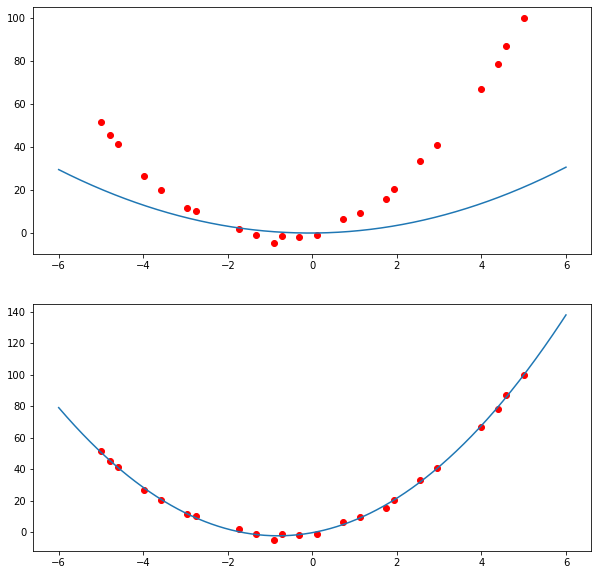

0

In [38]:
main(['', 'testfile.txt', 3, 10000])

In [ ]:
if __name__ == '__main__':
    import sys
    sys.exit(main(sys.argv))